**Проект: Прогнозирование заказов такси.**

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузим-и-изучим-данные." data-toc-modified-id="Загрузим-и-изучим-данные.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузим и изучим данные.</a></span></li><li><span><a href="#Предобработка-данных." data-toc-modified-id="Предобработка-данных.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных.</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных." data-toc-modified-id="Исследовательский-анализ-данных.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Исследовательский анализ данных.</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков." data-toc-modified-id="Создание-признаков.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков.</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Протестируем-модель-линейной-регрессии:" data-toc-modified-id="Протестируем-модель-линейной-регрессии:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Протестируем модель линейной регрессии:</a></span></li></ul></li><li><span><a href="#Общий-вывод." data-toc-modified-id="Общий-вывод.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод.</a></span></li>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# Основные шаги:

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Описание данных

Данные лежат в файле /datasets/taxi.csv.
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

- **datetime** - дата и время в которое совершались заказы.
- **num_orders** - количество заказов (целевой признак).

## Подготовка

### Загрузим и изучим данные.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

#%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import (cross_val_score, 
                                     GridSearchCV , 
                                     train_test_split, 
                                     TimeSeriesSplit)

from sklearn.metrics import (make_scorer, 
                             mean_squared_error)

import warnings
warnings.filterwarnings('ignore')

**Считаем данные из csv-файлов в датафреймы и сохраним в переменные.**

In [2]:
try:
    data_0 = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    print('Таблица /datasets/taxi.csv не была загружена')

**Выведем первые 5 строк датасета data_0 и информацию о них.**

In [3]:
#Сделаем обзор датасета data_0
display(data_0.shape)
display(data_0.info())
data_0.head()

(26496, 1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, в хронологическом ли порядке расположены даты.

In [4]:
data_0.index.is_monotonic

True

**Сделаем выводы по обзору данных:**

 - В исследовани участвует один датасет.
 - В датасете не обнаружено пропусков.
 - В датасете при загрузке был исправлен тип данных с object на datetime64.
 - Названия столбцов приведены к змеиному регистру.
 - Даты расположены в хронологическом порядке.

### Предобработка данных.

**Найдем явные дубликаты.**

In [5]:
#Посчитаем явные дубликаты
print('Количество явных дубликатов data_0:', data_0.duplicated().sum())

Количество явных дубликатов data_0: 26415


**Выполним ресемплирование данных по одному часу:**

<AxesSubplot:xlabel='datetime'>

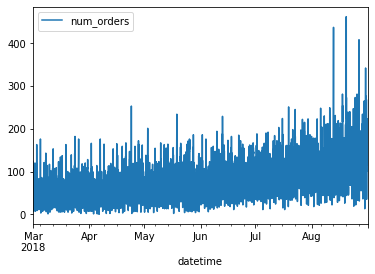

In [6]:
data_0 = data_0.resample('1H').sum() 
data_0.plot()

**Вывод:**

- Явных дубликатов не обнаружено.
- Неявные дубликаты нет смысла искать из-за особенностей данных.
- Пропусков в данных не обнаружено.
- Данные на графике с ресемплированием за 1 час имеют высокую частотность.

## Анализ

### Исследовательский анализ данных.

Для начала рассмотрим временной отрезок на котором происходит наблюдение.

In [7]:
print('Начало наблюдений:',data_0.index.min())
print('Конец наблюдений:',data_0.index.max())
print('Интервал наблюдений:',data_0.index.max() - data_0.index.min())
data_0.describe()

Начало наблюдений: 2018-03-01 00:00:00
Конец наблюдений: 2018-08-31 23:00:00
Интервал наблюдений: 183 days 23:00:00


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Вывод:** Мы видим, что наши данные состоят из 4416 записей, минимальное количество заказов в час равно 0, максимальное количество заказов в час равно 462, второй квартиль, т.е. медиана даёт показатель в 78 заказов в час. Так же мы видим, что интервал наблюдений составляет 183 дня 23 часа. Количества наблюдений должно быть достаточно для построения точной модели.

Рассмотрим скользящее среднее.

Text(0.5, 1.0, 'Скользящее среднее(50)')

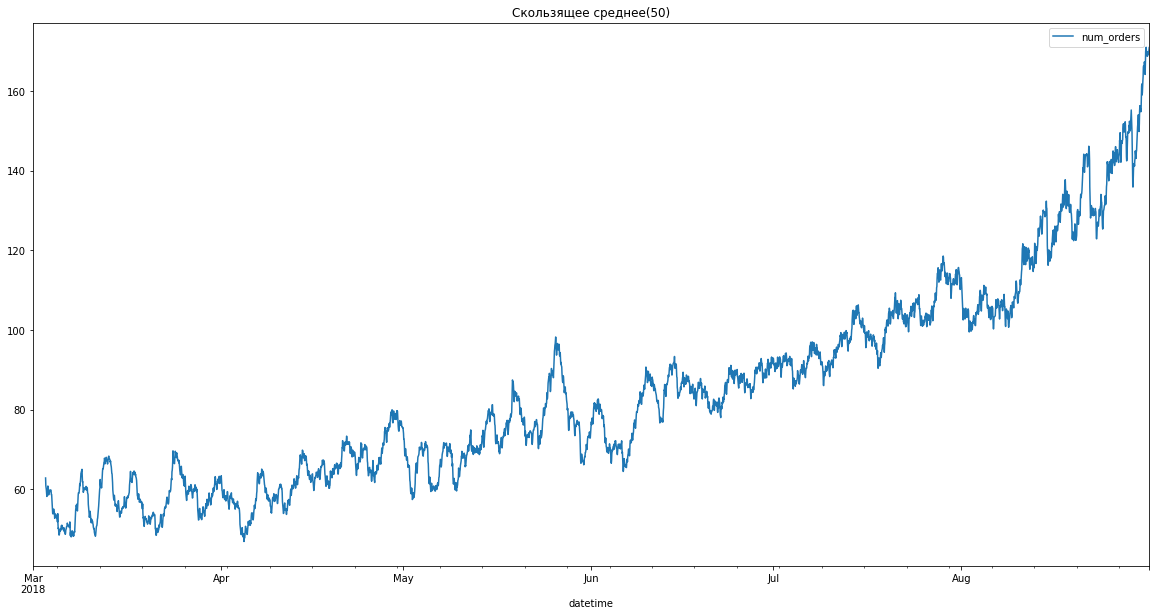

In [8]:
data_0.rolling(50).mean().plot(figsize=(20, 10))
plt.title('Скользящее среднее(50)')

Разложим временной ряд на тренд, сезонность и остаток.

Text(0.5, 1.0, 'Тренд')

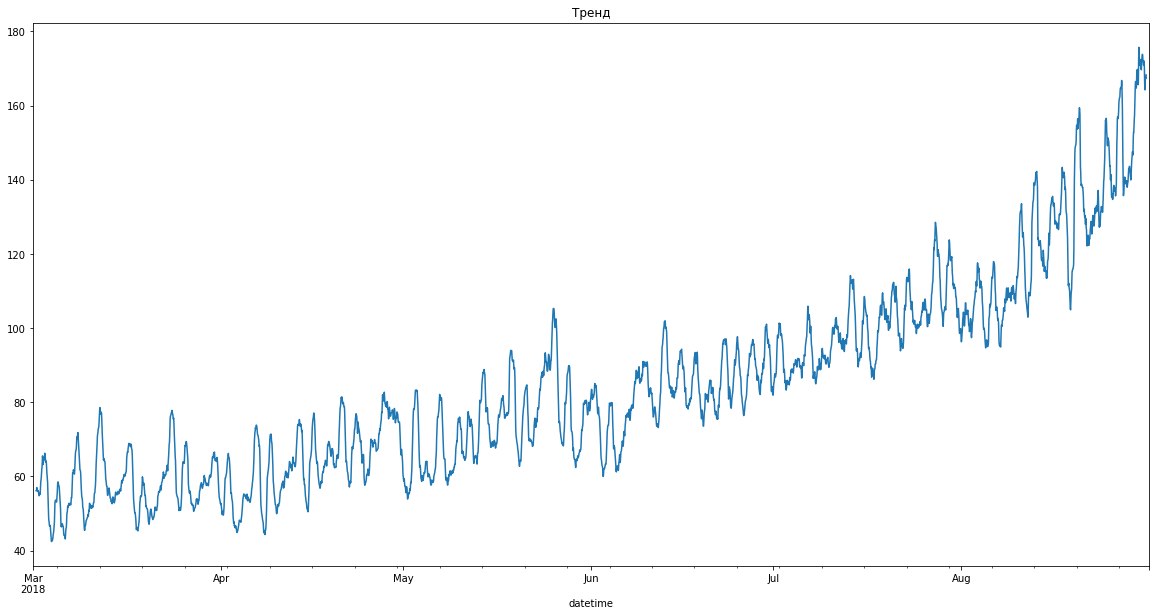

In [9]:
decomposed = seasonal_decompose(data_0)
decomposed.trend.plot(figsize=(20, 10)) # тренд
plt.title('Тренд')

**Вывод:** Из графиков видно, что тренд имеет восходящую тенденцию.

Text(0.5, 1.0, 'Сезонная составляющая')

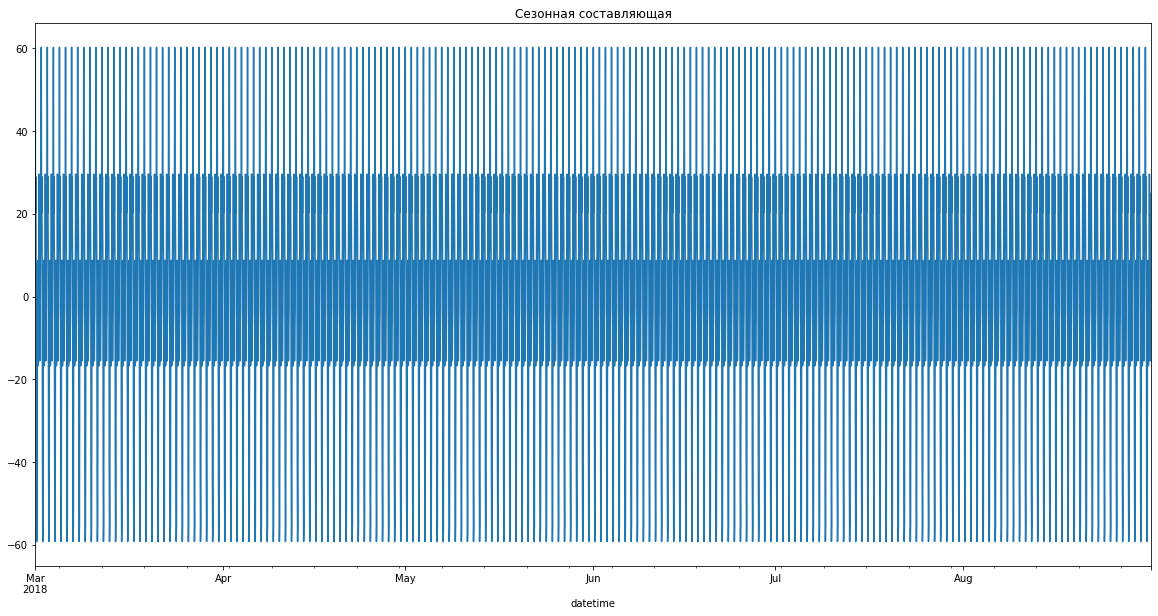

In [10]:
decomposed.seasonal.plot(figsize=(20, 10)) # сезонная составляющая
plt.title('Сезонная составляющая')

Text(0.5, 1.0, 'Остаток декомпозиции')

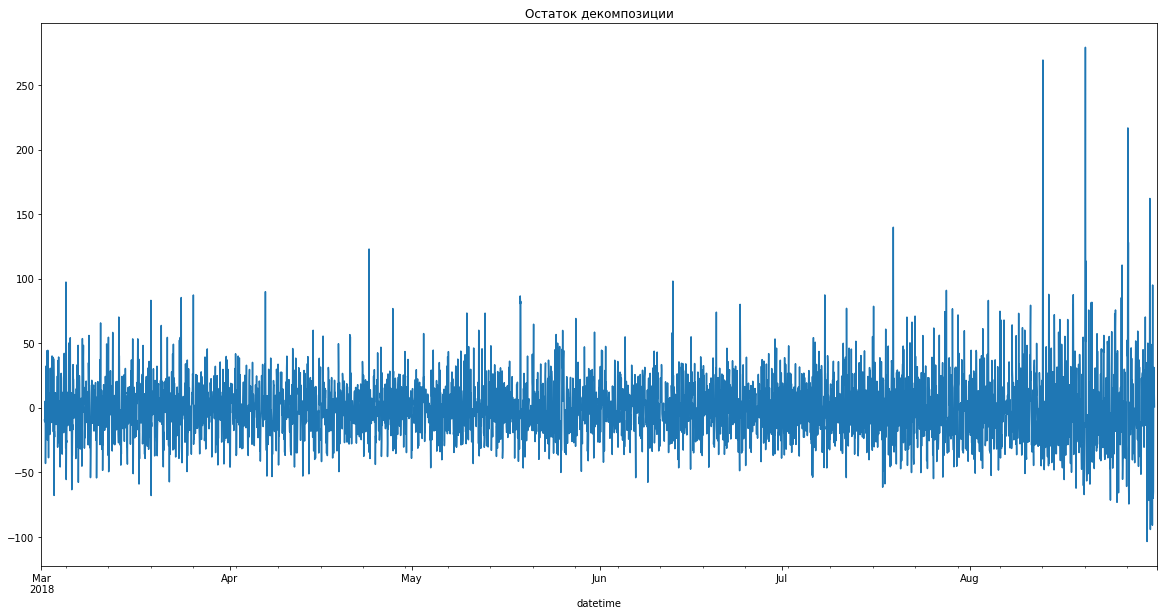

In [11]:
decomposed.resid.plot(figsize=(20, 10)) # остаток декомпозиции
plt.title('Остаток декомпозиции')

**Вывод:** Графики показывают высокую частотность. Так же мы видим суточную сезонность, но на таком большом временном интервале её сложно проследить. Построим графики для меньшего временного интервала.

Text(0.5, 1.0, 'Тренд')

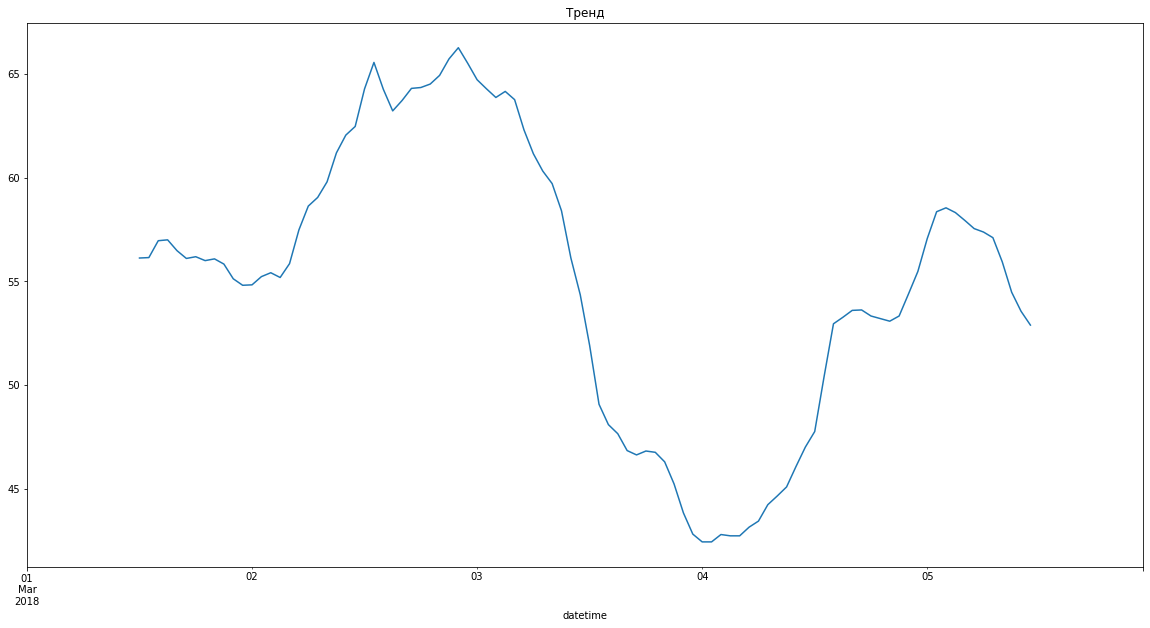

In [12]:
decomposed = seasonal_decompose(data_0['2018-03-01': '2018-03-05'])
decomposed.trend.plot(figsize=(20, 10)) # тренд
plt.title('Тренд')

Text(0.5, 1.0, 'Сезонная составляющая')

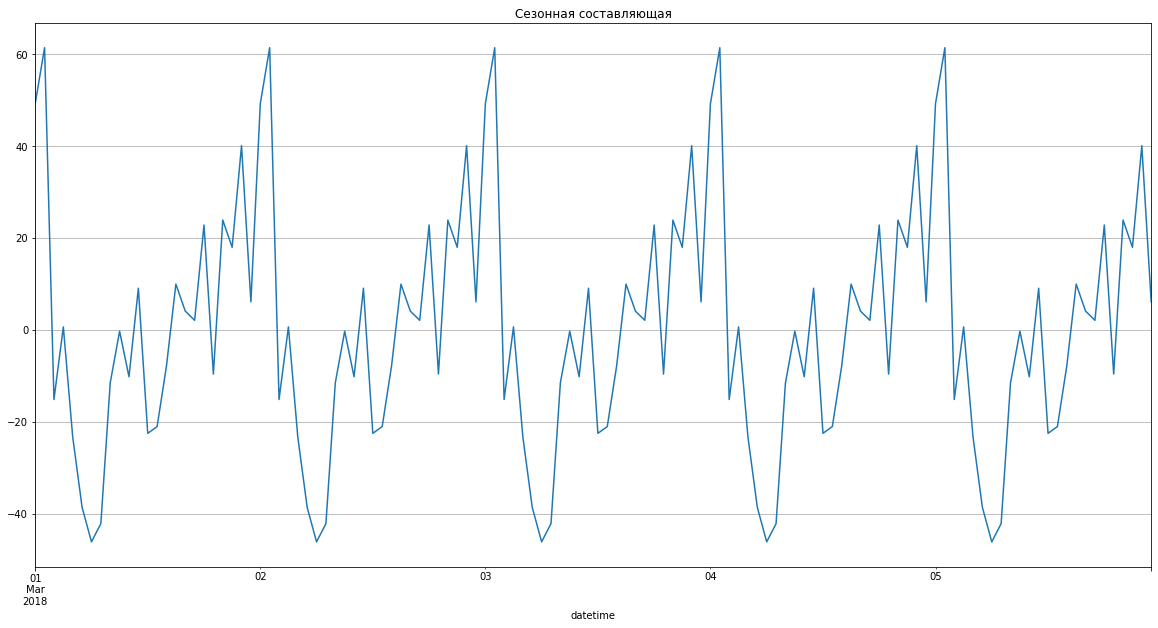

In [13]:
decomposed.seasonal.plot(figsize=(20, 10), grid=True) # сезонная составляющая
plt.title('Сезонная составляющая')

Text(0.5, 1.0, 'Остаток декомпозиции')

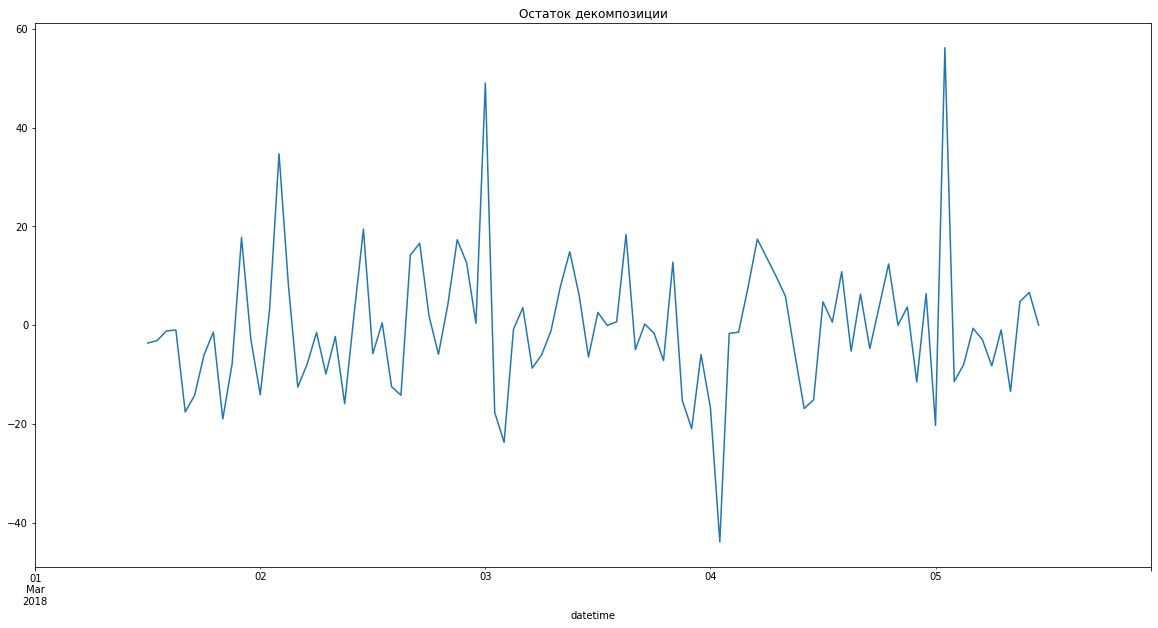

In [14]:
decomposed.resid.plot(figsize=(20, 10)) # остаток декомпозиции
plt.title('Остаток декомпозиции')

**Вывод:** Из графиков видно, что время суток влияет на количество заказов. Они достигают пика к полуночи, затем идет резкий спад, и постепенное возрастание заказов от шести утра.

Приверим недельную сезонность.

In [15]:
data_1 = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data_1

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [16]:
data_1.index.is_monotonic

True

<AxesSubplot:xlabel='datetime'>

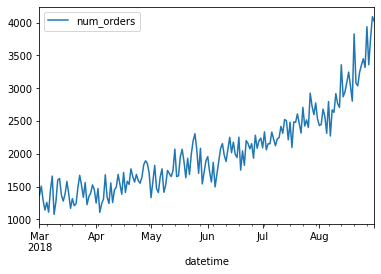

In [17]:
data_1 = data_1.resample('1D').sum() 
data_1.plot()

Text(0.5, 1.0, 'Недельная сезонная составляющая')

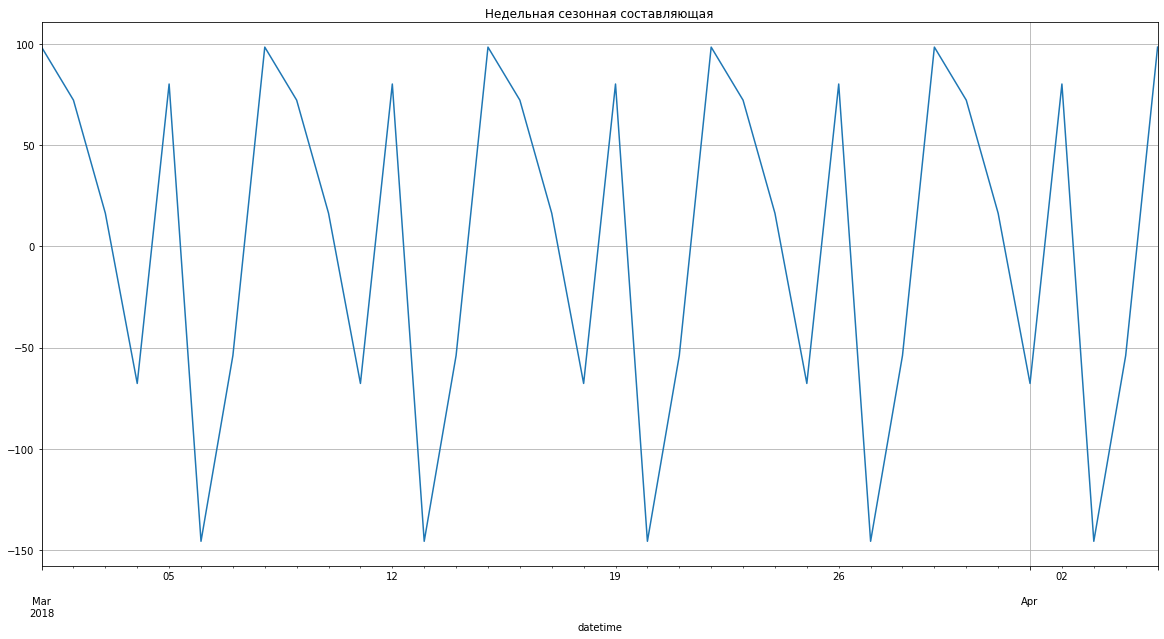

In [18]:
decomposed_1 = seasonal_decompose(data_1['2018-03-01': '2018-04-05'])
decomposed_1.seasonal.plot(figsize=(20, 10), grid=True) # сезонная составляющая
plt.title('Недельная сезонная составляющая')

**Вывод:** Мы наблюдаем явную недельную сезонность. В понедельник и четверг просматривается пик заказов. В остальные дни заказов сильно меньше.

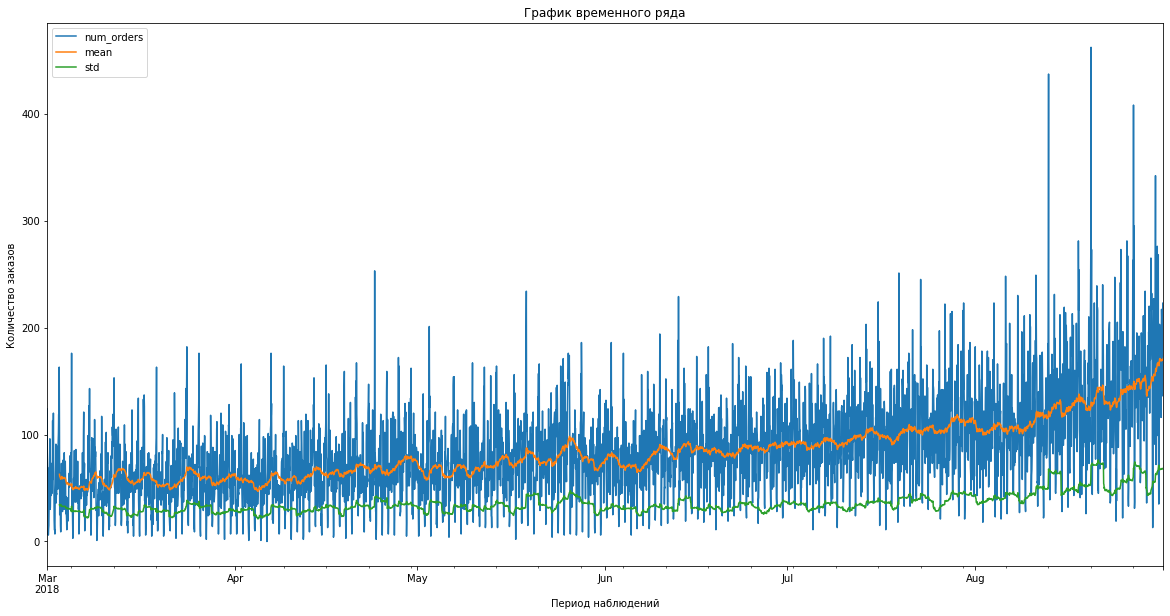

In [19]:
data_plt = data_0.copy()

data_plt['mean'] = data_plt['num_orders'].rolling(50).mean()
data_plt['std'] = data_plt['num_orders'].rolling(50).std()

data_plt.plot(figsize=(20, 10))
plt.title('График временного ряда')
plt.xlabel('Период наблюдений')
plt.ylabel('Количество заказов')
plt.show()

**Вывод:** Здесь наглядно видно, тенденцию к возрастанию на фоне шумного графика.

**Оформим общий вывод по результатам шага.**

**Вывод:**

- График за все время наблюдений имеет восходящую тенденцию.
- Просматривается суточная закономерность в количестве заказов.
- Количество заказов достигает пика к полуночи.
- Количество заказов достигает минимума к шести утра.

## Обучение

### Создание признаков.

На предыдущих этапах мы выявили четкую суточную сезонность, поэтому создадим признак 'hour' с часами заказа. Так же мы выявили четкую недельную сезонность, поэтому создадим признак 'day_of_week' с днями недели заказа. Так же нам важен будет 24-й лаг и 168 лаг, поэтому создадим признаки до 168-го лага.

In [20]:
data_0['day_of_week'] = data_0.index.dayofweek
data_0['hour'] = data_0.index.hour


for lag in range(1, 169):
    data_0['lag_{}'.format(lag)] = data_0['num_orders'].shift(lag)

    
data_0['rolling_mean'] = data_0['num_orders'].shift().rolling(50).mean()
data_0 = data_0.dropna()
    
    
data_0.head()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,53.38
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.80
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,55.42
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,55.88
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,55.74


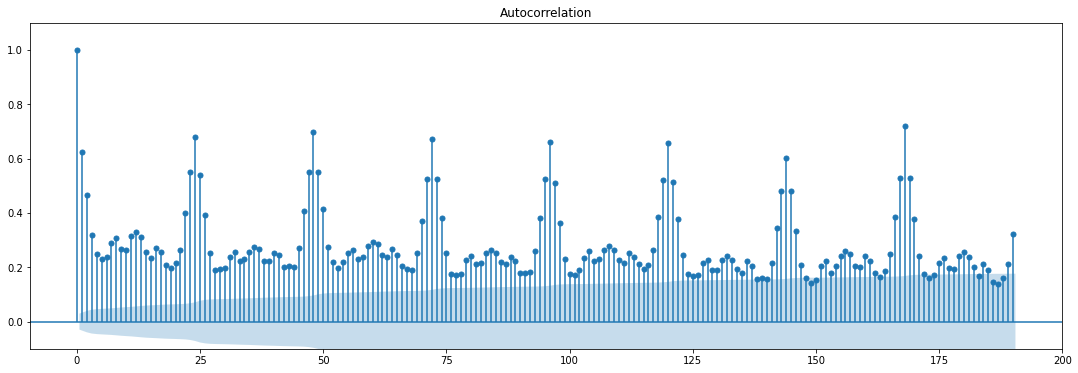

In [21]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



**Разделим данные на тренировочную и тестовую выборки.**

In [22]:
# Разделим данные на тренировочную и тестовую выборки
features = data_0.drop(['num_orders'], axis=1)
target = data_0['num_orders']
    
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            shuffle=False, 
                                                                            test_size=0.1)

In [23]:
# Проверим размеры выборок
display(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(3823, 171)

(3823,)

(425, 171)

(425,)

In [25]:
# Создадим функцию для подсчета RMSE
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
# С помощию функции make_scorer создим метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

**Модель LinearRegression**

In [25]:
%%time

tss = TimeSeriesSplit(n_splits=3).split(features_train)

# Обучим модель LinearRegression
m_linreg = LinearRegression(copy_X=True, 
                              fit_intercept=True, 
                              n_jobs=None, 
                              normalize=True)

m_linreg.fit(features_train, target_train)

#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(m_linreg,
                                                features_train,
                                                target_train,
                                                scoring=RMSE_score,
                                                cv=tss)).mean()*(-1)

print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 23.19566647563958
CPU times: user 759 ms, sys: 602 ms, total: 1.36 s
Wall time: 1.34 s


**Модель RandomForestRegressor**

In [26]:
%%time

tss = TimeSeriesSplit(n_splits=3).split(features_train)

# Обучим модель RandomForestRegressor()
rfr = RandomForestRegressor()
# Задаём параметры
rfr_param = { 'n_estimators': range(5, 25, 5),
                     'max_depth': range(1, 20, 2),
                     'min_samples_leaf': range(1,7),
                     'min_samples_split': range(2,6,2) }

rfr_grid = GridSearchCV(rfr,
                        rfr_param, 
                        scoring='neg_root_mean_squared_error', 
                        cv=tss)

rfr_grid.fit(features_train, target_train)

CPU times: user 24min 20s, sys: 883 ms, total: 24min 21s
Wall time: 24min 23s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f04dda82510>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 20, 2),
                         'min_samples_leaf': range(1, 7),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(5, 25, 5)},
             scoring='neg_root_mean_squared_error')

In [27]:
print('Среднее качество модели RandomForestRegressor на кросс-валидации:', rfr_grid.best_score_*(-1))

Среднее качество модели RandomForestRegressor на кросс-валидации: 24.02179962658842


**Обучим CatBoostRegressor.**

In [28]:
%%time

tss = TimeSeriesSplit(n_splits=3).split(features_train)

# Обучим модель RandomForestRegressor()
cbr = CatBoostRegressor()

# Задаём параметры
cbr_params = {'learning_rate': [0.04, 0.1],
                'depth': [3, 7, 10]
               }

cbr_grid = GridSearchCV(cbr, 
                       cbr_params, 
                       scoring=RMSE_score, 
                       cv=tss)

cbr_grid.fit(features_train, target_train, verbose=0)

CPU times: user 29min 46s, sys: 2.87 s, total: 29min 49s
Wall time: 30min 10s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f04dd9d4eb0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f04ddb04100>,
             param_grid={'depth': [3, 7, 10], 'learning_rate': [0.04, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [29]:
print('Среднее качество модели CatBoostRegressor на кросс-валидации:', cbr_grid.best_score_*(-1))

Среднее качество модели CatBoostRegressor на кросс-валидации: 23.86397006690451


**Вывод:** Лучшее качество на кросс-валидации показала модель LinearRegression - 23.1957. Мы выберем её для тестирования на тестовой выборке. У неё не только лучшее качество, но и сильно меньше, чем у других моделей время обучения и предсказания.

## Тестирование

Протестируем модель LinearRegression на тестовой выборке.

### Протестируем модель линейной регрессии:

In [30]:
model_lr = LinearRegression(copy_X=True, 
                                    fit_intercept=True, 
                                    n_jobs=None, 
                                    normalize=True)

model_lr.fit(features_train, target_train)
model_lr_pred = model_lr.predict(features_test)

#Выведем метрику RMSE
m_linreg_RMSE = round(RMSE(target_test, model_lr_pred), 5)
print('RMSE модели линейной регрессии:', m_linreg_RMSE)

RMSE модели линейной регрессии: 36.01941


In [31]:
def plot_1(pred):
    model = pd.DataFrame({"target":target_test, "predict":pred})
    model['2018-08-10':'2018-08-15'].plot(figsize=(18, 6))

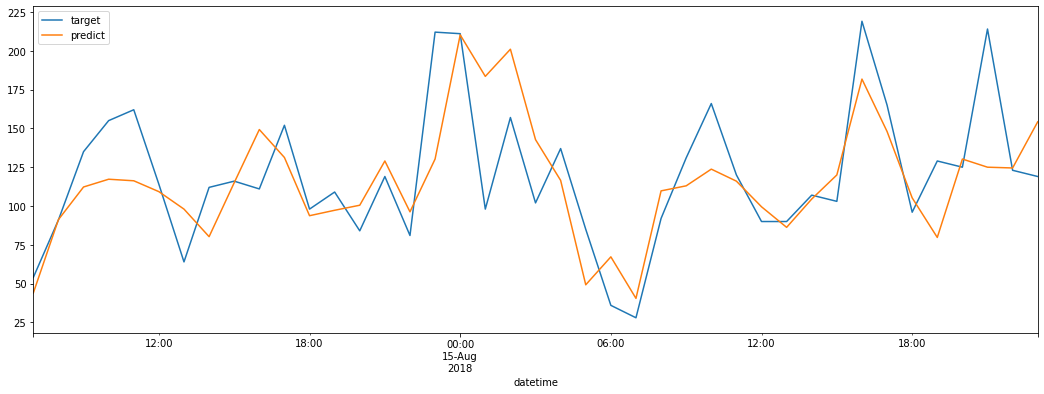

In [32]:
plot_1(model_lr_pred)

**Вывод:**
Модель LinearRegression смогла пройти критерии поставленной задачи и уложиться в RMSE - 48. Мы советуем выбрать модель LinearRegression. Её RMSE - 36.01941.

In [26]:
# код ревьюера
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

round(RMSE(target_test, pred_previous), 5)

58.81972

## Общий вывод.

**Сделаем общий вывод по проделанному исследованию.**

Мы исследовали датасет количеством заказов такси компании «Чётенькое такси». Компании нужно было построить модель, которая спрогнозирует количество заказов такси на следующий час. Критерий успешности модели - метрика RMSE ниже 48.

**Сделаем выводы по обзору данных:**

 - В исследовани участвует один датасет.
 - В датасете не обнаружено пропусков.
 - В датасете при загрузке был исправлен тип данных с object на datetime64.
 - Названия столбцов приведены к змеиному регистру.
 - Даты расположены в хронологическом порядке.
 
**Сделаем выводы по предобработке данных:**

- Явных дубликатов не обнаружено.
- Неявные дубликаты нет смысла искать из-за особенностей данных.
- Пропусков в данных не обнаружено.
- Данные на графике с ресемплированием за 1 час имеют высокую частотность.

**Сделаем вывод по исследовательскому анализу данных:**

Мы видим, что наши данные состоят из 4416 записей, минимальное количество заказов в час равно 0, максимальное количество заказов в час равно 462, второй квартиль, т.е. медиана даёт показатель в 78 заказов в час. Так же мы видим, что интервал наблюдений составляет 183 дня 23 часа. Количества наблюдений должно быть достаточно для построения точной модели.

- График за все время наблюдений имеет восходящую тенденцию.
- Просматривается суточная закономерность в количестве заказов.
- Количество заказов достигает пика к полуночи.
- Количество заказов достигает минимума к шести утра.

**Сделаем вывод по обучению моделей:** 

Лучшее качество на кросс-валидации показала модель LinearRegression - 23.1957. Мы выберем её для тестирования на тестовой выборке. У неё не только лучшее качество, но и сильно меньше, чем у других моделей время обучения и предсказания.

**Сделаем вывод по тестированию моделей:**

- Модель LinearRegression смогла пройти критерии поставленной задачи и уложиться в RMSE - 48. Мы советуем выбрать модель LinearRegression. Её RMSE - 36.01941. 